## Local Interpretable Model-agnostic Explanations

SHAP (SHapley Additive exPlanations) is another popular method for explaining machine learning models. It provides a unified measure of feature importance and can be used for both classification and regression models. Below is an example of how to use SHAP with a RandomForestClassifier for the binary classification problem.

In this code:

* We set a binary threshold on the median of y to create a binary classification target variable y_binary, where data points with y values above the median are labeled as 1 (high risk), and data points below or equal to the median are labeled as 0 (low risk).

* We train a Gradient Boosting Classifier on the modified target variable y_binary.

* We calculate the accuracy score on the test data to evaluate the classifier's performance.

* We create a SHAP explainer using shap.Explainer and provide the model and training data.

* We choose a prediction to explain (e.g., the first test data point), and we use explainer.shap_values to compute the SHAP values for that prediction.

* We visualize the SHAP values using shap.summary_plot to see the impact of each feature on the prediction.



In [4]:
# Installing the SHAP Python package
!pip install shap
# upgrading sklearn tot he latest version
!pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.3/455.3 kB 11.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 18.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.2
    Uninstalling scikit-learn-1.4.2:
      Successfully uninstalled scikit-learn-1.4.2


In [23]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap

random_state = 42

# Load the Diabetes dataset
diabetes_data = load_diabetes(scaled=False)
X = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
y = diabetes_data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Create and fit the Random Forest Classifier model with two classes (0 and 1)
# We are now using the original regression target variable y
model = GradientBoostingClassifier(n_estimators=100, random_state=random_state)
model.fit(X_train, (y_train > np.median(y)).astype(int))  # Use binary target variable here

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

# Calculate accuracy score
accuracy = accuracy_score((y_test > np.median(y)).astype(int), y_pred)  # Use binary target variable here
print("Accuracy on Test Data:", accuracy)



Accuracy on Test Data: 0.7191011235955056


In [25]:

# The kernel explainer receives the function that predicts the probability of classes and the train set as its main inputs.
explainer = shap.KernelExplainer(model.predict_proba, X_train)

# Computing the SHAP values using the samples in the test set.
shap_values = explainer(X_test)

# get just the explanations for the positive class
shap_values = shap_values[..., 1]


Using 353 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/89 [00:00<?, ?it/s]

We can use a bar plot for plotting the mean absolute value of the SHAP values each feature to provide a global explanation of the model.

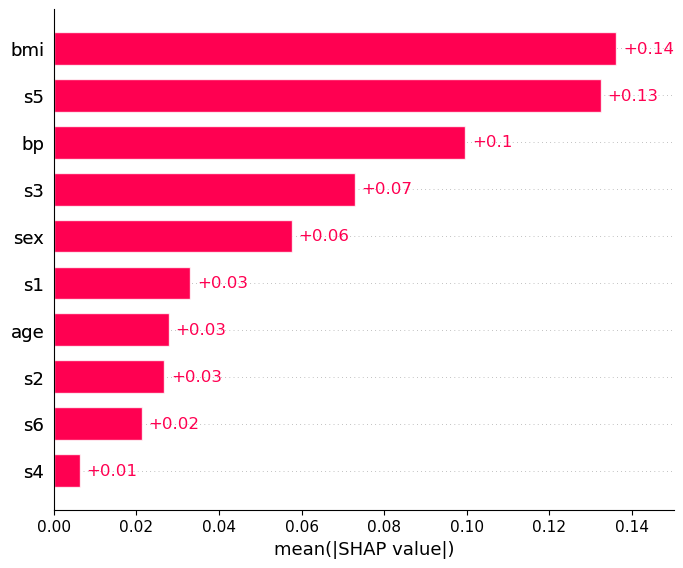

In [27]:
shap.plots.bar(shap_values)

We can use waterfall plot to illustrate the contribution of each feature in pushing the model output for a specific sample from the base value (the average model output over the training dataset we passed). Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. The plot has the following components:

* Base Value (Expected Value): The plot starts with the base value, which represents the expected prediction of the model over the entire dataset (i.e., the average prediction if no specific feature information is available).
This is usually shown as the first horizontal line on the plot.

* Feature Contributions (Shapley Values): Each subsequent step in the waterfall plot corresponds to the contribution of a feature to the model's prediction for the specific instance being explained. Features are listed in order of their impact on the prediction, with the largest contributing features (positive or negative) typically shown first.

* Positive and Negative Contributions: Features that increase the model’s prediction relative to the base value. They are represented by upward steps, moving the value higher. Features that decrease the prediction relative to the base value. These are shown as downward steps, lowering the prediction. Each step's length is proportional to the Shapley value of that feature, which represents how much that feature shifts the prediction from the base value.

* Final Prediction Value: The final value after all contributions from the features have been added to (or subtracted from) the base value is the model’s prediction for that particular instance. This is usually shown at the far right of the plo

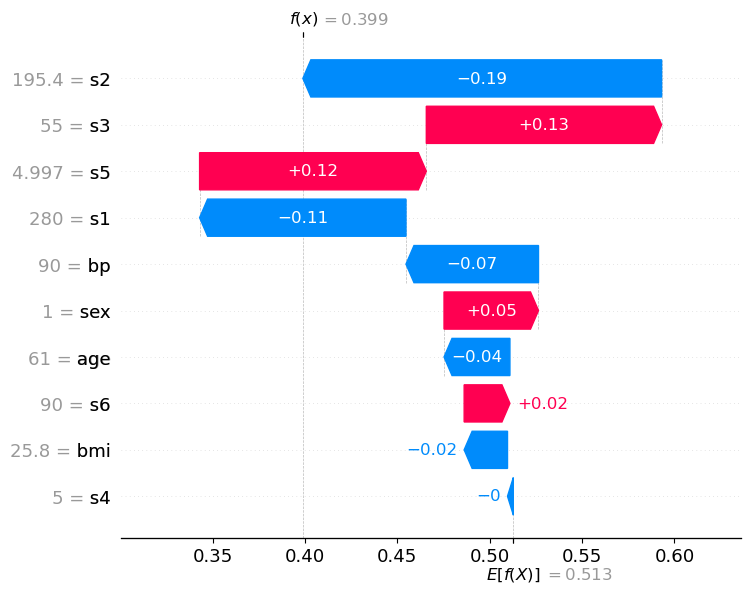

In [30]:
sample_id = 0
shap.plots.waterfall(shap_values[sample_id])


**Exercise 3.3:** Try `shap.explain.Exact` and `shap.TreeExplainer` and compare the running time and final feature attribution with shap.KernelExplainer (global snd local for at least five patients).

Local explanation for 5 patients:
Patient 1:


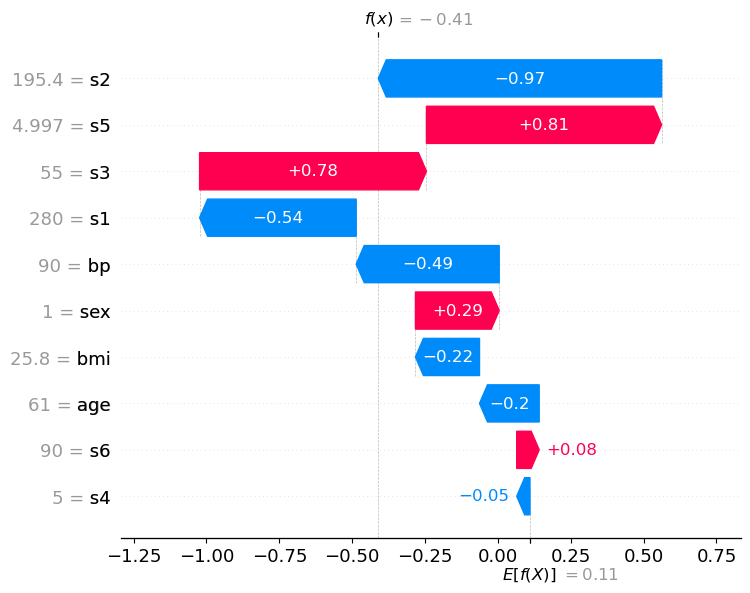

Patient 2:


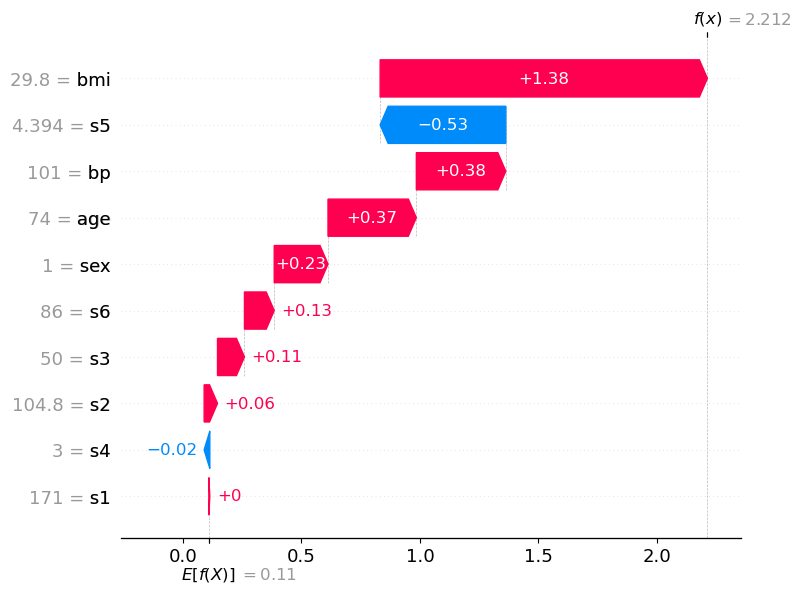

Patient 3:


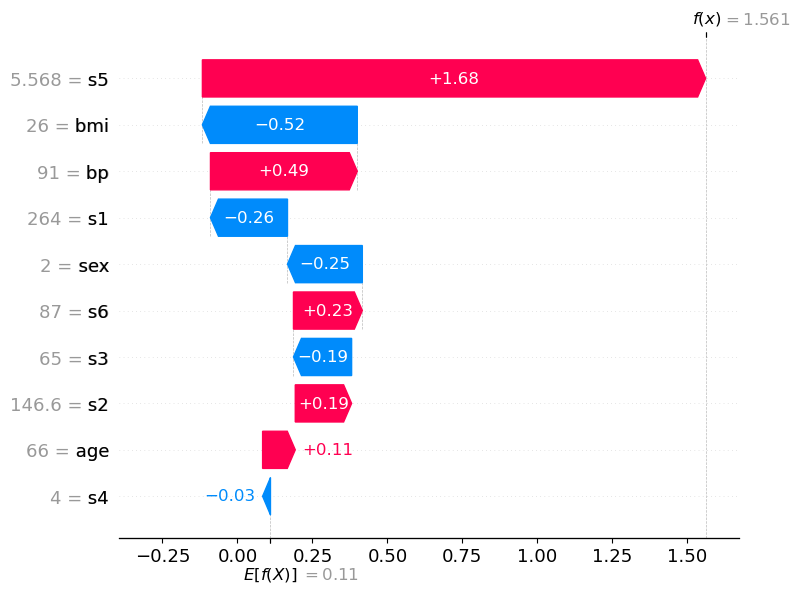

Patient 4:


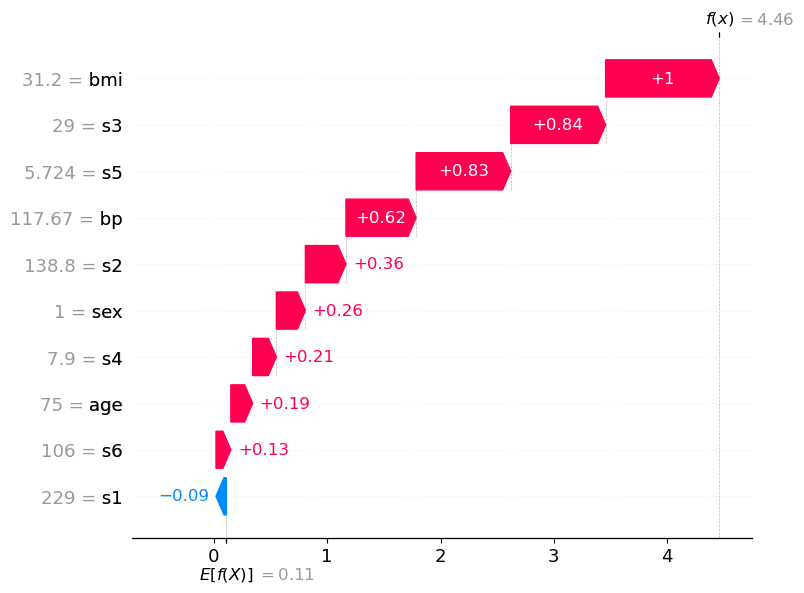

Patient 5:


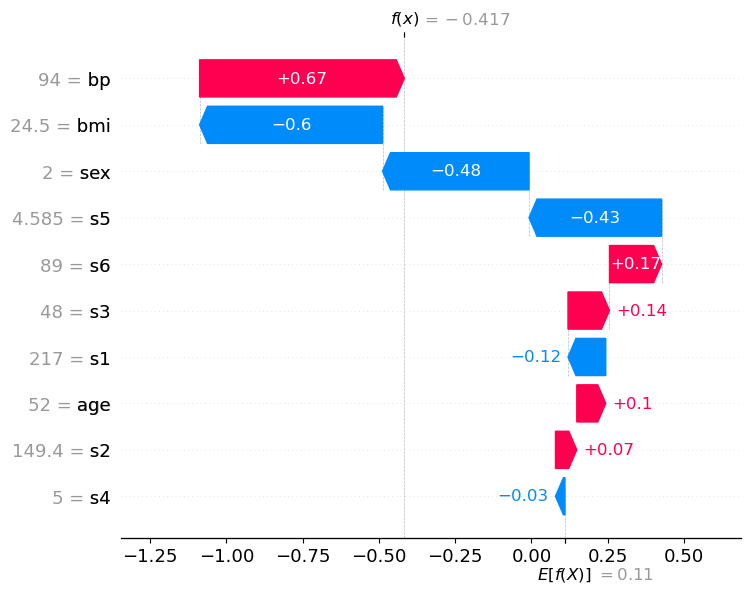

Global explanation for 5 patients:


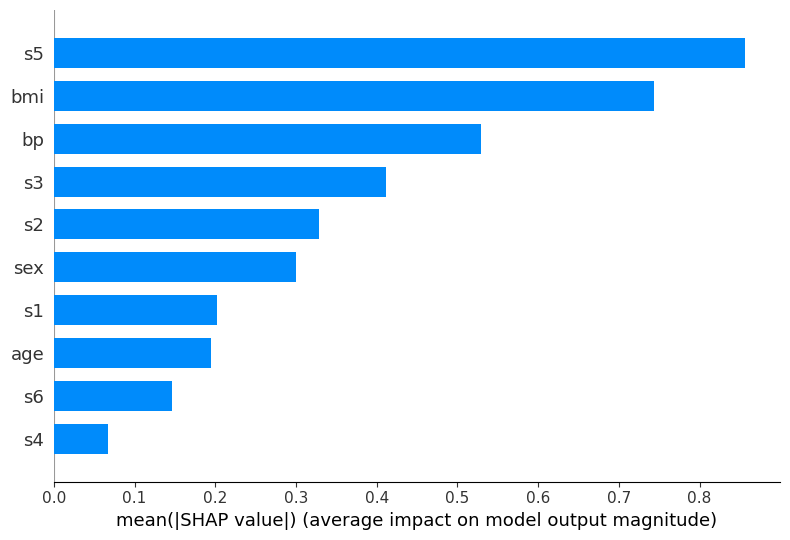

Running Time Comparison (in seconds):
TreeExplainer: 0.01 seconds
ExactExplainer: 4.69 seconds


In [67]:
import time
import matplotlib.pyplot as plt


tree_start_time = time.time()
tree_explainer = shap.TreeExplainer(model)
tree_shap_values = tree_explainer.shap_values(X_test)
tree_time_taken = time.time() - tree_start_time


exact_start_time = time.time()
exact_explainer = shap.explainers.Exact(model.predict_proba, X_train)
exact_shap_values = exact_explainer(X_test)
exact_time_taken = time.time() - exact_start_time

if isinstance(tree_shap_values, list):
    shap_values_to_use = tree_shap_values[1]  
    tree_expected_value = tree_explainer.expected_value[1]
else:
    shap_values_to_use = tree_shap_values
    tree_expected_value = tree_explainer.expected_value

print("Local explanation for 5 patients:")
for i in range(5):
    print(f"Patient {i+1}:")
    
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_to_use[i],  
            base_values=tree_expected_value, 
            data=X_test.iloc[i]
        )
    )
    plt.show()

print("Global explanation for 5 patients:")
shap.summary_plot(shap_values_to_use[:5], X_test.iloc[:5], plot_type="bar", title="Global Feature Attribution for 5 Patients")
plt.show()

print("Running Time Comparison (in seconds):")
print(f"TreeExplainer: {tree_time_taken:.2f} seconds")
print(f"ExactExplainer: {exact_time_taken:.2f} seconds")